<a href="https://colab.research.google.com/github/eylulyaltir/DSA210-Project/blob/main/machinelearning3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

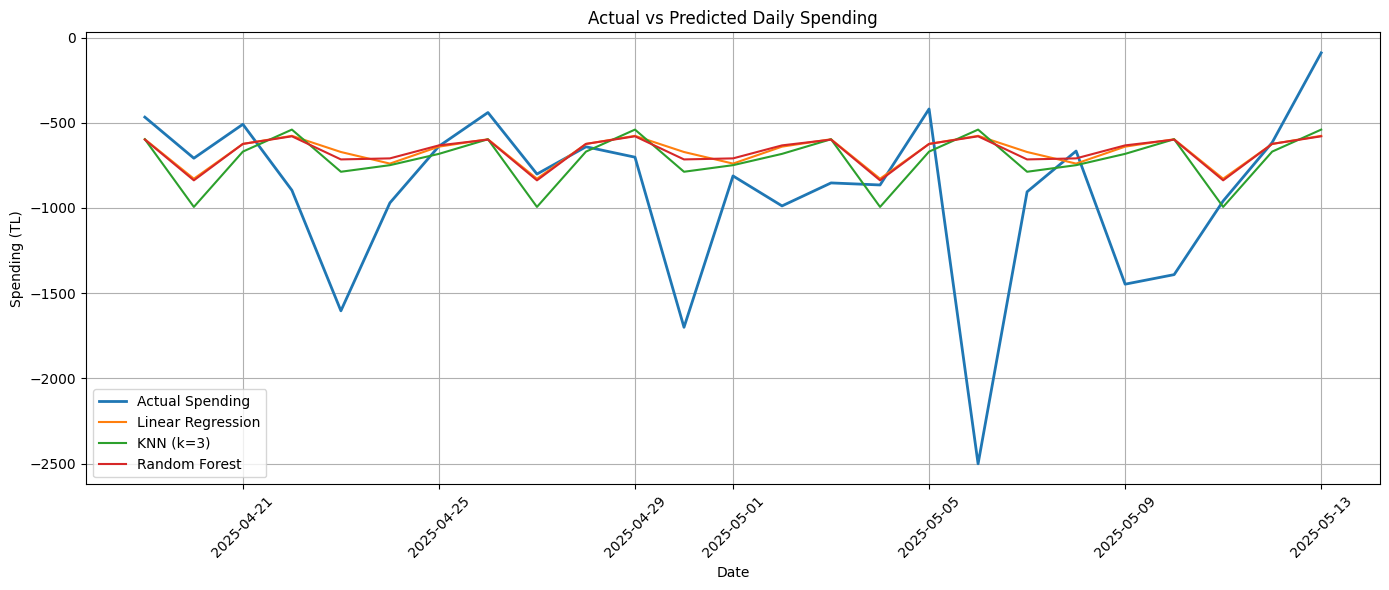

,Date,Actual,Pred_LR,Pred_KNN,Pred_RF
0,2025-04-19,-467.00,-596.753333,-596.753333,-598.947462
1,2025-04-20,-708.00,-828.298000,-993.833333,-837.823527
2,2025-04-21,-509.00,-624.380000,-669.300000,-624.024413
3,2025-04-22,-896.00,-576.660000,-540.166667,-579.454390
4,2025-04-23,-1603.46,-671.578000,-787.496667,-715.142267


In [2]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# --- STEP 1: LOAD & CLEAN TRAINING DATA (Past Transactions + Weather) ---
transactions = pd.read_csv("transactions.csv", sep=';')
weather = pd.read_excel("weatherdataset.xlsx")

# Clean transaction data
transactions['Date'] = pd.to_datetime(transactions['Date'].str[:10], errors='coerce')
transactions['Payment'] = (
    transactions['Payment']
    .str.replace(' TL', '', regex=False)
    .str.replace(',', '.')
    .str.strip()
)
transactions['Payment'] = pd.to_numeric(transactions['Payment'], errors='coerce')

# Clean weather data
weather['Date'] = pd.to_datetime(weather['datetime'], errors='coerce')
weather = weather[['Date', 'temp', 'humidity', 'feelslike', 'windspeed', 'conditions']]

# Merge and enrich
merged = pd.merge(transactions, weather, on='Date', how='inner')
merged['day_of_week'] = merged['Date'].dt.day_name()
merged['is_weekend'] = merged['Date'].dt.weekday >= 5

# Aggregate to daily spending
daily = merged.groupby(['Date', 'day_of_week', 'is_weekend'])['Payment'].sum().reset_index()
X_train = pd.get_dummies(daily[['day_of_week', 'is_weekend']], drop_first=True)
y_train = daily['Payment']

# --- STEP 2: LOAD & ENRICH FORECAST WEATHER DATA ---
forecast_df = pd.read_excel("finalweatherdata.xlsx")
forecast_df = forecast_df[['datetime', 'temp', 'humidity', 'feelslike', 'windspeed', 'conditions']].copy()
forecast_df.rename(columns={'datetime': 'Date'}, inplace=True)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'], errors='coerce')
forecast_df['day_of_week'] = forecast_df['Date'].dt.day_name()
forecast_df['is_weekend'] = forecast_df['Date'].dt.weekday >= 5

# Prepare forecast features
X_forecast = pd.get_dummies(forecast_df[['day_of_week', 'is_weekend']], drop_first=True)
X_forecast = X_forecast.reindex(columns=X_train.columns, fill_value=0)

# --- STEP 3: TRAIN MODELS & MAKE PREDICTIONS ---
lr = LinearRegression().fit(X_train, y_train)
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

forecast_df['Pred_LR'] = lr.predict(X_forecast)
forecast_df['Pred_KNN'] = knn.predict(X_forecast)
forecast_df['Pred_RF'] = rf.predict(X_forecast)

# --- STEP 4: LOAD ACTUAL TRANSACTIONS FOR COMPARISON ---
actuals = pd.read_csv("Hesap HareketleriML.csv", sep=';')
actuals['Date'] = pd.to_datetime(actuals['Date'].str[:10], errors='coerce')
actuals['Payment'] = (
    actuals['Payment']
    .str.replace(' TL', '', regex=False)
    .str.replace(',', '.')
    .str.strip()
)
actuals['Payment'] = pd.to_numeric(actuals['Payment'], errors='coerce')
actual_daily = actuals.groupby('Date')['Payment'].sum().reset_index()

# --- STEP 5: MERGE & COMPARE ---
comparison_df = pd.merge(forecast_df, actual_daily, on='Date', how='inner')
comparison_df.rename(columns={'Payment': 'Actual'}, inplace=True)

# --- STEP 6: PLOT ACTUAL VS PREDICTED ---
plt.figure(figsize=(14, 6))
sns.lineplot(data=comparison_df, x='Date', y='Actual', label='Actual Spending', linewidth=2)
sns.lineplot(data=comparison_df, x='Date', y='Pred_LR', label='Linear Regression')
sns.lineplot(data=comparison_df, x='Date', y='Pred_KNN', label='KNN (k=3)')
sns.lineplot(data=comparison_df, x='Date', y='Pred_RF', label='Random Forest')
plt.title('Actual vs Predicted Daily Spending')
plt.ylabel('Spending (TL)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

comparison_df[['Date', 'Actual', 'Pred_LR', 'Pred_KNN', 'Pred_RF']].head()


The graph illustrates the comparison between actual daily spending and predicted spending over a 30-day period using three machine learning models: Linear Regression, K-Nearest Neighbors (KNN), and Random Forest. While the overall spending trends are captured reasonably well by all models, the Random Forest and KNN models provide closer approximations to the actual spending, particularly during mid-range values, whereas Linear Regression underperforms on days with spending extremes. This visualization highlights the models’ ability to approximate general spending behavior, though it also shows limitations in predicting sharp fluctuations.